In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from scipy.ndimage import map_coordinates
# from skimage.registration import diffeomorphic_metric_mapping
from skimage.transform import resize, rescale, rotate
from skimage.util import img_as_ubyte

import requests
from io import BytesIO
import tifffile as tf
import nrrd
import pickle
import random

import seaborn as sns
sns.set_context('talk')

In [2]:
cd ..

/Users/TingshanLiu/Desktop/2020 fall/NDD


In [3]:
!ln -s scikit-image/skimage/registration/_lddmm.py _lddmm.py

ln: _lddmm.py: File exists


In [4]:
from _lddmm import diffeomorphic_metric_mapping

In [5]:
with open('data.pickle', 'rb') as f:
     data = pickle.load(f)

In [6]:
(X_train, y_train) = data[0]
(X_test, y_test) = data[1]

In [7]:
data_x = np.concatenate([X_train, X_test])
# data_x = data_x.reshape((data_x.shape[0], data_x.shape[1] * data_x.shape[2] * data_x.shape[3]))
data_y = np.concatenate([y_train, y_test])
data_y = data_y[:, 0]

In [8]:
def cross_val_data(data_x, data_y, total_cls=10):
    x = data_x.copy()
    y = data_y.copy()
    idx = [np.where(data_y == u)[0] for u in np.unique(data_y)]


    for i in range(total_cls):
        indx = idx[i]#np.roll(idx[i],(cv-1)*100)
        random.shuffle(indx)

        if i==0:
            train_x1 = x[indx[0:250],:]
            train_x2 = x[indx[250:500],:]
            train_y1 = y[indx[0:250]]
            train_y2 = y[indx[250:500]]

            test_x = x[indx[500:600],:]
            test_y = y[indx[500:600]]
        else:
            train_x1 = np.concatenate((train_x1, x[indx[0:250],:]), axis=0)
            train_x2 = np.concatenate((train_x2, x[indx[250:500],:]), axis=0)
            train_y1 = np.concatenate((train_y1, y[indx[0:250]]), axis=0)
            train_y2 = np.concatenate((train_y2, y[indx[250:500]]), axis=0)

            test_x = np.concatenate((test_x, x[indx[500:600],:]), axis=0)
            test_y = np.concatenate((test_y, y[indx[500:600]]), axis=0)


    return train_x1, train_y1, train_x2, train_y2, test_x, test_y

In [10]:
train_x1, train_y1, train_x2, train_y2, test_x, test_y = cross_val_data(data_x, data_y, total_cls=10)

In [11]:
def image_aug(pic, angle, centroid_x=23, centroid_y=23, win=16, scale=1.45):
    im_sz = int(np.floor(pic.shape[0]*scale))
    pic_ = np.uint8(np.zeros((im_sz,im_sz,3),dtype=int))

    pic_[:,:,0] = ndimage.zoom(pic[:,:,0],scale)

    pic_[:,:,1] = ndimage.zoom(pic[:,:,1],scale)
    pic_[:,:,2] = ndimage.zoom(pic[:,:,2],scale)

    image_aug = rotate(pic_, angle, resize=False)
    #print(image_aug.shape)
    image_aug_ = image_aug[centroid_x-win:centroid_x+win,centroid_y-win:centroid_y+win,:]

    return img_as_ubyte(image_aug_)

In [114]:
# w/ aug
# angles = np.arange(0, 180, 30)
angles = [30]
tmp_data_all = {}
for angle in angles:
    tmp_data = train_x2.copy()
    # _tmp_ = np.zeros((32,32,3), dtype=int)
    total_data = tmp_data.shape[0]
    for i in range(total_data):
        tmp_ = image_aug(tmp_data[i], angle)
        tmp_data[i] = tmp_
    tmp_data_all[angle] = tmp_data

In [53]:
# # w/o aug
# # angles = np.arange(0, 180, 30)
# tmp_data_all_NoAug = {}
# for angle in angles:
#     tmp_data = train_x2.copy()
#     total_data = tmp_data.shape[0]
#     for i in range(total_data):
#         tmp_ = rotate(tmp_data[i], angle)
#         tmp_data[i] = tmp_
#     tmp_data_all_NoAug[angle] = tmp_data

In [17]:
# with open('tmp_data_all.pickle', 'wb') as f:
#     pickle.dump(tmp_data_all, f)

In [101]:
# angles = np.arange(30, 180, 30)
angles = [30]
tmp_data_al_rotated_deformed = {}
for angle in angles:
    print(angle)
    tmp_data = tmp_data_all[angle]
    total_data = tmp_data.shape[0]
    for i in range(total_data):
        print(i)
        target_image = tmp_data[i]
        reference_image = train_x2[i]
        try:
            lddmm_output = diffeomorphic_metric_mapping(reference_image, target_image)
        except RuntimeError:
            try:
                lddmm_output = diffeomorphic_metric_mapping(reference_image, target_image, affine_stepsize=0.1)
            except RuntimeError:
                try:
                    lddmm_output = diffeomorphic_metric_mapping(reference_image, target_image, affine_stepsize=0.05)
                except RuntimeError:
                    lddmm_output = diffeomorphic_metric_mapping(reference_image, target_image, affine_stepsize=0.01)
        deformed_target_image = map_coordinates(target_image,lddmm_output.moving_image_to_reference_image_transform)
        tmp_data[i] = deformed_target_image
    tmp_data_al_rotated_deformed[angle] = tmp_data

30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


LinAlgError: This exception may have been raised because thecontrast_polynomial_basis vectors were notindependent, i.e. the reference_image is constant.

In [185]:
i = 18
target_image = tmp_data[i]
reference_image = train_x2[i]
lddmm_output = diffeomorphic_metric_mapping(reference_image, target_image, affine_stepsize=0.01)

In [186]:
deformed_target_image = map_coordinates(target_image,lddmm_output.moving_image_to_reference_image_transform)

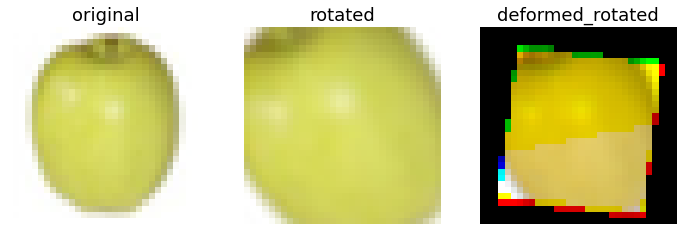

In [204]:
fig,axs = plt.subplots(1,3,figsize=(12,4))
pics = [reference_image, target_image, deformed_target_image]
names = ["original", "rotated", "deformed_rotated"]
for i in range(len(pics)):
    ax = axs[i]
    ax.imshow(pics[i])
    ax.set(title=names[i])
    ax.axis("off")